In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import logging
import random
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
class DataLoader:
    def __init__(self, folder):
        self._folder = folder
        self._images = []
        self._labels = []
        self._filenames = []
        self._setup_logging()
        
    def _setup_logging(self):
        """Set up logging for the DataLoader class"""
        self.logger = logging.getLogger('DataLoader')
        if not self.logger.handlers:
            self.logger.setLevel(logging.INFO)
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def load_data(self, to_grayscale=False, image_size=(64, 64), max_images=None, extract_labels=False):
        """
        Load images from the specified folder
        
        Parameters:
        -----------
        to_grayscale : bool
            Whether to convert images to grayscale
        image_size : tuple
            Size to resize images to
        max_images : int or None
            Maximum number of images to load, or None for all
        extract_labels : bool
            Whether to extract labels from directory structure
            
        Returns:
        --------
        List of images as numpy arrays
        """
        self._images = []
        self._filenames = []
        self._labels = []
        
        folder_path = Path(self._folder)
        image_files = []
        
        # Find all image files
        for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.gif']:
            image_files.extend(list(folder_path.glob(f'**/*{ext}')))
            image_files.extend(list(folder_path.glob(f'**/*{ext.upper()}')))
        
        # Sample if max_images is specified
        if max_images is not None and max_images < len(image_files):
            image_files = random.sample(image_files, max_images)
            
        self.logger.info(f"Loading {len(image_files)} images from {self._folder}")
        
        for img_path in image_files:
            try:
                img = Image.open(img_path)
                img = img.resize(image_size)
                img = img.convert('RGBA')
                
                img_np = np.array(img)
                if to_grayscale:
                    r = img_np[:, :, 0]
                    g = img_np[:, :, 1]
                    b = img_np[:, :, 2]
                    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
                    img_np = gray.astype(np.uint8)
                
                self._images.append(img_np)
                self._filenames.append(str(img_path))
                
                # Extract label from parent directory name if requested
                if extract_labels:
                    label = img_path.parent.name
                    self._labels.append(label)
                    
            except Exception as e:
                self.logger.error(f"Error loading image {img_path}: {e}")
                
        self.logger.info(f"Successfully loaded {len(self._images)} images")
        return self._images

    def get_images(self):
        return self._images
        
    def get_labels(self):
        return self._labels
        
    def get_filenames(self):
        return self._filenames
    
    def display_image(self, index):
        """
        Display an image at the specified index
        
        Parameters:
        -----------
        index : int
            Index of the image to display
        """
        if 0 <= index < len(self._images):
            plt.imshow(self._images[index])
            plt.axis('off')
            plt.show()
        else:
            self.logger.error(f"Index {index} out of range. Cannot display image.")

In [3]:
class FeatureExtractor:
    def __init__(self):
        self._features = []
        self._feature_names = []
        self._setup_logging()
        
    def _setup_logging(self):
        """Set up logging for the FeatureExtractor class"""
        self.logger = logging.getLogger('FeatureExtractor')
        if not self.logger.handlers:
            self.logger.setLevel(logging.INFO)
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
    
    def _rgb_to_gray(self, rgb_img):
        """Convert RGB image to grayscale using standard coefficients"""
        return np.dot(rgb_img[..., :3], [0.2989, 0.5870, 0.1140])
    
    def extract_features(self, images, method='all', params=None):
        """
        Extract features from images and return them as a DataFrame
        
        Parameters:
        -----------
        images : list
            List of image arrays to extract features from
        method : str
            The feature extraction method to use:
            - 'histogram': Color/intensity histogram
            - 'basic_stats': Basic statistics like mean, std, etc.
            - 'contrast': Image contrast features
            - 'color_variance': Color variance features
            - 'dominant_colors': Dominant colors in the image
            - 'edge_density': Simple edge detection and density calculations
            - 'all': Combine all feature types (default)
        params : dict
            Additional parameters for specific extraction methods
                
        Returns:
        --------
        DataFrame with image features (one row per image)
        """
        if not images:
            self.logger.warning("No images provided for feature extraction.")
            return pd.DataFrame()
            
        if params is None:
            params = {}
        
        self.logger.info(f"Extracting features using method: {method}")
        
        # Process the first image to determine all feature names
        first_features = self._extract_image_features(images[0], method, params)
        
        # Create DataFrame with the right columns and pre-allocate rows
        feature_names = list(first_features.keys())
        self._features = pd.DataFrame(columns=feature_names, index=range(len(images)), dtype=float)
        
        # Set the first row with already extracted features
        self._features.iloc[0] = list(first_features.values())
        
        # Process the rest of the images
        for i in range(1, len(images)):
            if i % 100 == 0:
                self.logger.info(f"Processed {i}/{len(images)} images")
                
            features = self._extract_image_features(images[i], method, params)
            self._features.iloc[i] = list(features.values())
        
        # Store feature names for reference
        self._feature_names = feature_names
        
        self.logger.info(f"Extracted features for {len(self._features)} images with {len(feature_names)} dimensions each")
        return self._features

    def _extract_image_features(self, img_np, method, params):
        """Extract features from a single image"""
        features = {}  # Use a dictionary to store features with their names
        
        if len(img_np.shape) == 2:  # If grayscale
            img_gray = img_np
            # Create RGB version if needed
            img_rgb = np.stack((img_np,) * 3, axis=-1)
        else:  # If color
            img_rgb = img_np[:, :, :3]  # Use RGB channels
            img_gray = self._rgb_to_gray(img_rgb)
        
        # 1. Basic statistical features
        if method in ['basic_stats', 'all']:
            # Intensity statistics
            features['intensity_mean'] = float(np.mean(img_gray))
            features['intensity_std'] = float(np.std(img_gray))
            features['intensity_min'] = float(np.min(img_gray))
            features['intensity_max'] = float(np.max(img_gray))
            features['intensity_median'] = float(np.median(img_gray))
            
            # Shape statistics
            height, width = img_gray.shape
            features['height'] = float(height)
            features['width'] = float(width)
            features['aspect_ratio'] = float(width / height)
            
            # Higher order statistics
            intensity_mean = features['intensity_mean']
            intensity_std = features['intensity_std']
            features['skewness'] = float(np.mean(((img_gray - intensity_mean) / (intensity_std + 1e-8)) ** 3))
            features['kurtosis'] = float(np.mean(((img_gray - intensity_mean) / (intensity_std + 1e-8)) ** 4) - 3)
        
        # 2. Histogram features
        if method in ['histogram', 'all']:
            bins = params.get('hist_bins', 32)
            if len(img_np.shape) > 2:  # Color image
                for channel in range(min(3, img_np.shape[2])):
                    hist, _ = np.histogram(img_np[:, :, channel], bins=bins, range=(0, 256))
                    hist = hist.astype(float) / hist.sum()
                    channel_name = ['R', 'G', 'B'][channel]
                    for bin_idx, value in enumerate(hist):
                        features[f'hist_{channel_name}_{bin_idx}'] = float(value)
            else:  # Grayscale
                hist, _ = np.histogram(img_np, bins=bins, range=(0, 256))
                hist = hist.astype(float) / hist.sum()
                for bin_idx, value in enumerate(hist):
                    features[f'hist_gray_{bin_idx}'] = float(value)
        
        # 3. Contrast features
        if method in ['contrast', 'all']:
            # Global contrast: standard deviation of pixel values
            features['global_contrast'] = float(np.std(img_gray))
            
            # Local contrast: average of local standard deviations
            local_size = params.get('local_contrast_size', 7)
            if local_size < min(img_gray.shape):
                local_contrasts = []
                for i_local in range(0, img_gray.shape[0] - local_size, local_size):
                    for j in range(0, img_gray.shape[1] - local_size, local_size):
                        patch = img_gray[i_local:i_local+local_size, j:j+local_size]
                        local_contrasts.append(np.std(patch))
                features['local_contrast'] = float(np.mean(local_contrasts) if local_contrasts else 0)
            else:
                features['local_contrast'] = features['global_contrast']
        
        # 4. Color variance features
        if method in ['color_variance', 'all'] and len(img_np.shape) > 2:
            # Variance of each color channel
            features['variance_R'] = float(np.var(img_rgb[:,:,0]))
            features['variance_G'] = float(np.var(img_rgb[:,:,1]))
            features['variance_B'] = float(np.var(img_rgb[:,:,2]))
            
            # Color diversity: variance between channel means
            channel_means = [np.mean(img_rgb[:,:,c]) for c in range(3)]
            features['color_diversity'] = float(np.var(channel_means))
        
        # 5. Dominant colors
        if method in ['dominant_colors', 'all'] and len(img_np.shape) > 2:
            num_colors = params.get('num_dominant_colors', 3)

            # Reshape image to be a list of pixels
            pixels = img_rgb.reshape(-1, 3)

            # Sample pixels for faster processing
            sample_size = min(1000, pixels.shape[0])
            sampled_pixels = pixels[np.random.choice(pixels.shape[0], sample_size, replace=False)]
            
            # Use K-means to find dominant colors
            kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init=10)
            kmeans.fit(sampled_pixels)
            
            # Get colors and their proportions
            dominant_colors = kmeans.cluster_centers_
            labels = kmeans.labels_
            counts = np.bincount(labels)
            proportions = counts / sample_size
            
            # Add each dominant color and proportion as separate columns
            for color_idx in range(num_colors):
                features[f'dom_color_{color_idx}_R'] = float(dominant_colors[color_idx, 0])
                features[f'dom_color_{color_idx}_G'] = float(dominant_colors[color_idx, 1])
                features[f'dom_color_{color_idx}_B'] = float(dominant_colors[color_idx, 2])
                features[f'dom_color_{color_idx}_proportion'] = float(proportions[color_idx])
        
        # 6. Edge density features (simple replacement for HOG)
        if method in ['edge_density', 'all']:
            # Simple gradient-based edge detection
            gy, gx = np.gradient(img_gray)
            edge_magnitude = np.sqrt(gx**2 + gy**2)
            
            # Edge density features
            features['edge_mean'] = float(np.mean(edge_magnitude))
            features['edge_std'] = float(np.std(edge_magnitude))
            
            # Threshold-based edge density
            threshold = params.get('edge_threshold', 0.1)
            features['edge_density'] = float(np.mean(edge_magnitude > threshold))
            
            # Directional gradients
            features['gradient_x_mean'] = float(np.mean(np.abs(gx)))
            features['gradient_x_std'] = float(np.std(np.abs(gx)))
            features['gradient_y_mean'] = float(np.mean(np.abs(gy)))
            features['gradient_y_std'] = float(np.std(np.abs(gy)))
        
        return features

In [4]:
class DataAnalyzer:
    def __init__(self):
        self._df = None  # Internal storage for the DataFrame
        self._setup_logging()  # Initialize logging

    def get_df(self):
        """Return the currently loaded DataFrame."""
        return self._df

    def _setup_logging(self):
        """Set up a logger for the DataAnalyzer class."""
        self.logger = logging.getLogger('DataAnalyzer')
        if not self.logger.handlers:
            self.logger.setLevel(logging.INFO)
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def load_data(self, df):
        """
        Load a DataFrame for analysis.
        Parameters:
        - df: A pandas DataFrame to be stored and analyzed.
        """
        if not isinstance(df, pd.DataFrame):
            self.logger.error("Input must be a pandas DataFrame")
            raise ValueError("Input must be a pandas DataFrame")
        self._df = df
        self.logger.info(f"Data loaded with shape {df.shape}")

    def summary_statistics(self):
        """
        Return basic descriptive statistics (mean, std, min, max, etc.)
        for numeric columns in the DataFrame.
        """
        if self._df is None:
            self.logger.warning("No data loaded")
            return None

        numeric_df = self._df.select_dtypes(include='number')
        
        if numeric_df.empty:
            self.logger.error("No numeric columns found in the DataFrame.")
            return None

        return numeric_df.describe()


    def sort_by_feature(self, feature, ascending=True):
        """
        Sort the DataFrame by a specific feature.
        Parameters:
        - feature: column name to sort by
        - ascending: sort direction (True for ascending, False for descending)
        """
        if self._df is None:
            self.logger.warning("No data loaded")
            return None
        if feature not in self._df.columns:
            self.logger.warning(f"Feature '{feature}' not found in columns")
            return None
        return self._df.sort_values(by=feature, ascending=ascending)

    def filter_by_threshold(self, feature, threshold, above=True):
        """
        Filter rows based on whether a feature's value is above or below a threshold.
        Parameters:
        - feature: column name to filter on
        - threshold: numeric value to compare against
        - above: if True, returns rows with value > threshold; else <= threshold
        """
        if self._df is None:
            self.logger.warning("No data loaded")
            return None
        if feature not in self._df.columns:
            self.logger.warning(f"Feature '{feature}' not found in columns")
            return None
        if above:
            return self._df[self._df[feature] > threshold]
        else:
            return self._df[self._df[feature] <= threshold]
        
    def get_most_common_dominant_color(self):
        """
        Calculate the average RGB values of the top 3 dominant colors across the dataset.
        Expects the DataFrame to include columns like:
        'dom_color_0_R', 'dom_color_0_G', 'dom_color_0_B',
        'dom_color_1_R', 'dom_color_1_G', 'dom_color_1_B',
        'dom_color_2_R', 'dom_color_2_G', 'dom_color_2_B'.
        
        Returns:
            pd.DataFrame: A DataFrame with average RGB values for each dominant color.
        """
        if self._df is None:
            self.logger.warning("No data loaded.")
            return None

        required_columns = [
            'dom_color_0_R', 'dom_color_0_G', 'dom_color_0_B',
            'dom_color_1_R', 'dom_color_1_G', 'dom_color_1_B',
            'dom_color_2_R', 'dom_color_2_G', 'dom_color_2_B'
        ]

        missing_columns = [col for col in required_columns if col not in self._df.columns]
        if missing_columns:
            self.logger.error(f"Missing expected color columns: {missing_columns}")
            return None

        avg_colors = {
            'color_0': [
                self._df['dom_color_0_R'].mean(),
                self._df['dom_color_0_G'].mean(),
                self._df['dom_color_0_B'].mean()
            ],
            'color_1': [
                self._df['dom_color_1_R'].mean(),
                self._df['dom_color_1_G'].mean(),
                self._df['dom_color_1_B'].mean()
            ],
            'color_2': [
                self._df['dom_color_2_R'].mean(),
                self._df['dom_color_2_G'].mean(),
                self._df['dom_color_2_B'].mean()
            ]
        }

        avg_colors_df = pd.DataFrame.from_dict(avg_colors, orient='index', columns=['red', 'green', 'blue'])
        return avg_colors_df

    
    def mean_diff_by_feature(self, feature):
        """
        Create a new column in the DataFrame containing the difference between
        each value in the specified feature column and its mean.

        Parameters:
        -----------
        feature : str
            The name of the column for which to calculate mean difference.

        Returns:
        --------
        DataFrame
            A copy of the DataFrame with an additional column showing the
            difference from the mean for the specified feature.
        """
        if self._df is None:
            self.logger.warning("No data loaded")
            return None

        # Check if the feature exists in the DataFrame
        if feature not in self._df.columns:
            self.logger.warning(f"Feature '{feature}' not found in DataFrame")
            return None

        # Calculate the mean of the selected feature
        feature_mean = self._df[feature].mean()

        # Create a new column name
        column_name = f"{feature} difference"

        # Create a copy of the original DataFrame
        self._df_copy = self._df.copy()

        # Subtract the mean from each value in the feature column
        self._df_copy[column_name] = self._df[feature] - feature_mean

        # Return the updated DataFrame with the new column
        return self._df_copy



In [5]:
class Visualizer:
    def __init__(self,dataframe):
        self._df = dataframe.get_df()

#  DataAnalyzer-style operations 

# 1. Summary statistics
        self._summary_stats = self._df.describe()

# 2. Sort by edge_density
        self._sorted_df = self._df.sort_values(by='edge_density')

# 3. Filter by edge_density > 0.5
        self._filtered_df = self._df[self._df['edge_density'] > 0.5]

# 4. Average dominant color (Color 0)
        self._avg_color = {
            'red': self._df['dom_color_0_R'].mean(),
            'green': self._df['dom_color_0_G'].mean(),
            'blue': self._df['dom_color_0_B'].mean()
        }

# 5. Mean difference column for intensity_mean
        self._mean_diff_df = self._df.copy()
        self._mean_diff_df['intensity_mean_diff'] = self._df['intensity_mean'] - self._df['intensity_mean'].mean()

# Plots

# 1. Histogram of intensity_mean
    def hist_plot(self):
        plt.figure()
        plt.hist(self._df['intensity_mean'], bins=10, edgecolor='black')
        plt.title('Histogram of Intensity Mean')
        plt.xlabel('Intensity Mean')
        plt.ylabel('Frequency')
        plt.show()
        return
# 2. Scatter plot of intensity_mean vs intensity_std
    def scatter_plot(self):
        plt.figure()
        plt.scatter(self._df['intensity_mean'], self._df['intensity_std'], alpha=0.7)
        plt.title('Scatter Plot: Intensity Mean vs Std')
        plt.xlabel('Intensity Mean')
        plt.ylabel('Intensity Std')
        plt.show()
        return
# 3. Box plot of dominant color channels
    def box_plot(self):
        plt.figure()
        plt.boxplot([self._df['dom_color_0_R'], self._df['dom_color_0_G'], self._df['dom_color_0_B']], labels=['Red', 'Green', 'Blue'])
        plt.title('Box Plot of Dominant Color Channels')
        plt.show()
        return
# 4. Line plot of intensity_mean difference
    def line_plot(self):
        plt.figure()
        plt.plot(self._mean_diff_df['intensity_mean_diff'], marker='o')
        plt.title('Line Plot of Intensity Mean Difference from Mean')
        plt.xlabel('Sample Index')
        plt.ylabel('Difference from Mean')
        plt.show()
        return
# 5. Bar chart of average RGB values
    def bar_chart(self):
        plt.figure()
        plt.bar(['Red', 'Green', 'Blue'], [self._avg_color['red'], self._avg_color['green'], self._avg_color['blue']])
        plt.title('Bar Chart of Average Dominant Color (Color 0)')
        plt.ylabel('Average Value')
        plt.show()
        return
    
    
    def plotting(self):
        self.hist_plot()
        self.scatter_plot()
        self.box_plot()
        self.line_plot()
        self.bar_chart()

2025-05-14 20:02:22,122 - DataLoader - INFO - Loading 100 images from c:\Users\UserX\Desktop\AUA\Freshman Sem2\Prog\Project\Humans
2025-05-14 20:02:22,122 - DataLoader - INFO - Loading 100 images from c:\Users\UserX\Desktop\AUA\Freshman Sem2\Prog\Project\Humans
2025-05-14 20:02:26,818 - DataLoader - INFO - Successfully loaded 100 images
2025-05-14 20:02:26,818 - DataLoader - INFO - Successfully loaded 100 images
2025-05-14 20:02:26,818 - FeatureExtractor - INFO - Extracting features using method: all
2025-05-14 20:02:26,818 - FeatureExtractor - INFO - Extracting features using method: all
2025-05-14 20:02:33,524 - FeatureExtractor - INFO - Extracted features for 100 images with 131 dimensions each
2025-05-14 20:02:33,524 - FeatureExtractor - INFO - Extracted features for 100 images with 131 dimensions each
2025-05-14 20:02:33,540 - DataAnalyzer - INFO - Data loaded with shape (100, 131)
2025-05-14 20:02:33,540 - DataAnalyzer - INFO - Data loaded with shape (100, 131)


Loaded 100 images with 131 features each.
Data types in DataFrame:
intensity_mean      float64
intensity_std       float64
intensity_min       float64
intensity_max       float64
intensity_median    float64
                     ...   
edge_density        float64
gradient_x_mean     float64
gradient_x_std      float64
gradient_y_mean     float64
gradient_y_std      float64
Length: 131, dtype: object
Features DataFrame:
Index(['intensity_mean', 'intensity_std', 'intensity_min', 'intensity_max',
       'intensity_median', 'height', 'width', 'aspect_ratio', 'skewness',
       'kurtosis',
       ...
       'dom_color_2_G', 'dom_color_2_B', 'dom_color_2_proportion', 'edge_mean',
       'edge_std', 'edge_density', 'gradient_x_mean', 'gradient_x_std',
       'gradient_y_mean', 'gradient_y_std'],
      dtype='object', length=131)
       intensity_mean  intensity_std  intensity_min  intensity_max  \
count      100.000000     100.000000     100.000000     100.000000   
mean       118.951521      

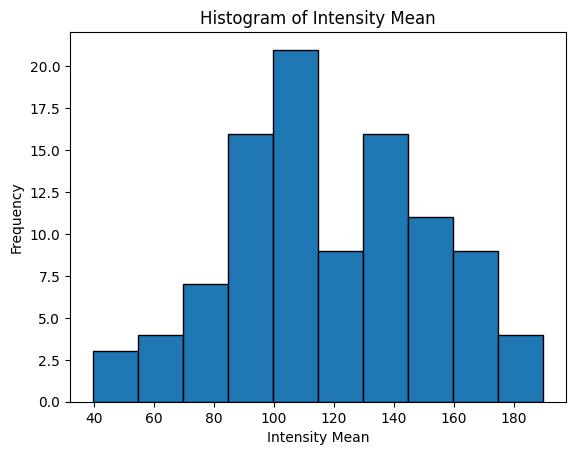

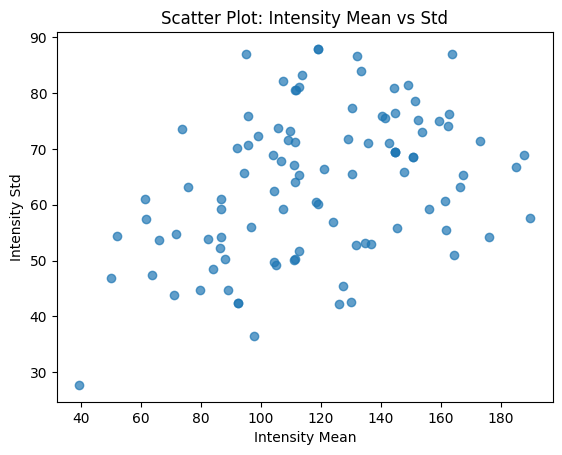

C:\Users\UserX\AppData\Local\Temp\ipykernel_22616\1520275423.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([self._df['dom_color_0_R'], self._df['dom_color_0_G'], self._df['dom_color_0_B']], labels=['Red', 'Green', 'Blue'])


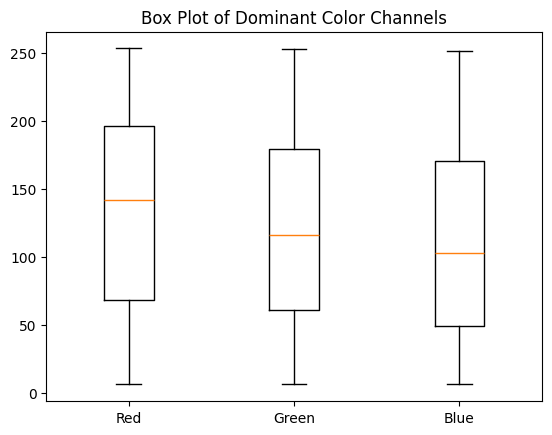

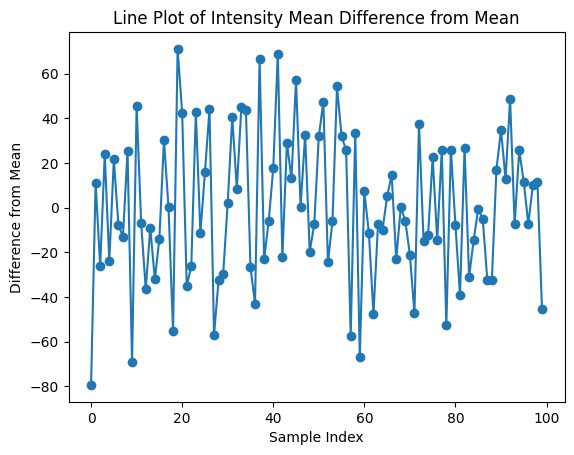

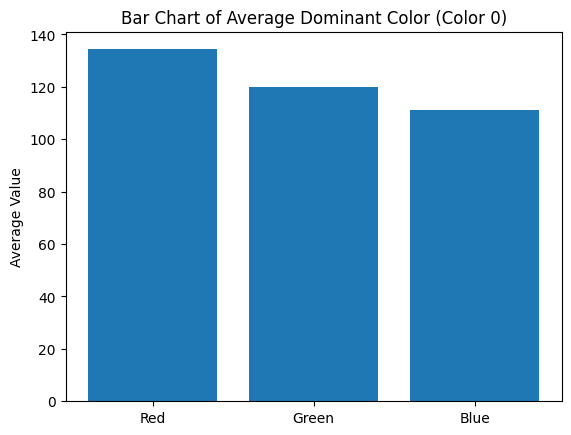

In [6]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

folder = r"c:\Users\UserX\Desktop\AUA\Freshman Sem2\Prog\Project\Humans"
    
# Load the images
data_loader = DataLoader(folder)
images = data_loader.load_data(
    to_grayscale=False,
    image_size=(64, 64), 
    max_images=100, 
    extract_labels=True
)
    
feature_extractor = FeatureExtractor()
features_df = feature_extractor.extract_features(
    images,
    method='all',  # Choose the feature extraction method
    params={
        'hist_bins': 32,            # Histogram parameters
        'num_dominant_colors': 3,   # Number of dominant colors to extract
        'local_contrast_size': 7,   # Patch size for local contrast
        'edge_threshold': 0.1       # Threshold for edge detection
    }
)
    
    
labels = data_loader.get_labels()
filenames = data_loader.get_filenames()
    
print(f"Loaded {len(images)} images with {len(features_df.columns)} features each.")
    
        
# Give data on datatypes in the DataFrame
print("Data types in DataFrame:")
print(features_df.dtypes)
     
# Display features data
print("Features DataFrame:")
print(features_df.columns)
        
# Display analysis
data_analyzer = DataAnalyzer()
data_analyzer.load_data(features_df)
print(data_analyzer.summary_statistics())
data_analyzer.sort_by_feature('intensity_mean', ascending=False)
data_analyzer.filter_by_threshold('intensity_mean', 0.5, above=True)


# Display visualizer
visualizer=Visualizer(data_analyzer)
visualizer.plotting()